<font color = 'Orange' size = 6> Satellite Dataset-RSI-CB256 trained with VGG16 Architecture</font>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
import os
helper_methods_folder = '/content/drive/MyDrive/AI Project/Model Training/helper_methods'

sys.path.append(os.path.abspath(helper_methods_folder))

**Importing helper methods for preprocessing, training and plotting**

In [3]:
from preprocessing import load_data
from plots import plot_data_loader, show_examples
from plots import plot_accuracy, plot_loss,plot_training_batch_loss, plot_confusion_matrix
from training import train_model, compute_accuracy_and_loss
from early_stopping import EarlyStopping
from metrics import compute_classification_report, compute_confusion_matrix
from unnormalize_images import UnNormalize
from predictions import predict_image_class

**Importing Libraries**

In [4]:
from torchvision import models
import torch.nn as nn
import torch
import matplotlib.pyplot as plt


In [5]:
root_dir = r'/content/drive/MyDrive/AI Project/Datasets/Satellite Dataset-RSI-CB256/data'
path_to_save_model=r"/content/drive/MyDrive/AI Project/Model Training/Satellite_datatset_weights/"
file_name = "satellite_dataset_RESNET"

**Load the datasets into train_loader, validation loader and test loader**

In [6]:
train_loader, test_loader, valid_loader, data = load_data(root_dir, test_split=0.2, val_split=0.1, batch_size=32, input_size=[64,64])

In [ ]:
# checking the train loader dataset information
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([32, 3, 64, 64])
Image label dimensions: torch.Size([32])
Class labels of 10 examples: tensor([3, 3, 0, 0, 0, 3, 2, 3, 3, 2])


**Encodings for the classes**

In [7]:
label_encoding = data.class_to_idx  
print("label mapping is ", label_encoding)   # save these mapping for predicition  

label mapping is  {'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}


**Plot the data loader**

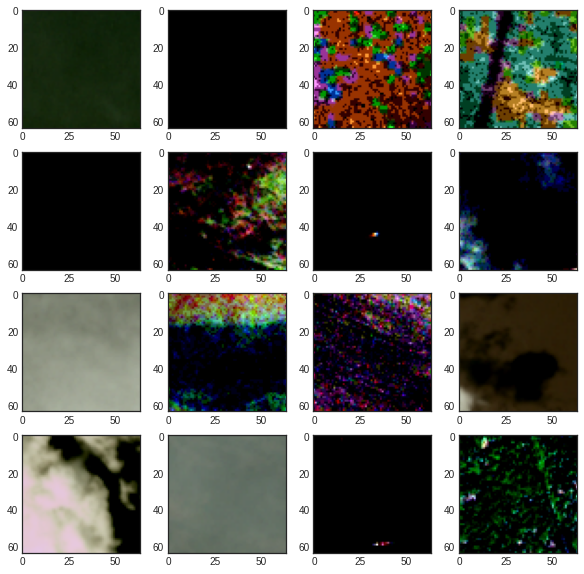

In [ ]:
plot_data_loader(train_loader, (4,4))

**Load RESNET50 Model** 

In [8]:
model = models.resnet50(pretrained=False) # By default, no pre-trained weights are used.
print(model)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Change the number of outputs classes in the last layer of the model**

In [9]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4) #num_classes = 4
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Set the hyperparameters**

In [10]:
# define the loss function for multi-class classifictaion
criterion = nn.CrossEntropyLoss()


#Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 3, verbose=False)

# create and early stopping object which will be used during the training
early_stopping = EarlyStopping(tolerance=3, min_delta=0.01)

num_epochs = 40

**Train the Model with train_loader and perform validation with valid_loader**

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
print("Device: {}".format(device))

model.to(device)

minibatch_loss_list, train_acc_list, valid_acc_list, train_loss_list, valid_loss_list = train_model(
    model=model,
    num_epochs=num_epochs,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion = criterion,
    optimizer=optimizer,
    device=device,
    early_stopping=early_stopping,
    file_name = file_name,
    path_to_save_model=path_to_save_model,
    scheduler=scheduler)

Device: cuda:0
Epoch: 001/040 | Batch 0000/0124 | Loss: 1.4259
Epoch: 001/040 | Batch 0100/0124 | Loss: 0.6059
Epoch: 001/040 | Train ACC: 46.88% | Validation ACC: 68.03%| Train LOSS: 0.9503| Validation LOSS: 0.9796
Time elapsed: 12.70 min
Epoch: 002/040 | Batch 0000/0124 | Loss: 1.0513
Epoch: 002/040 | Batch 0100/0124 | Loss: 0.7073
Epoch: 002/040 | Train ACC: 67.19% | Validation ACC: 73.36%| Train LOSS: 0.7176| Validation LOSS: 0.7295
Time elapsed: 13.02 min
Epoch: 003/040 | Batch 0000/0124 | Loss: 0.6237
Epoch: 003/040 | Batch 0100/0124 | Loss: 0.8124
Epoch: 003/040 | Train ACC: 75.00% | Validation ACC: 75.67%| Train LOSS: 0.6380| Validation LOSS: 0.6460
Time elapsed: 13.33 min
Epoch: 004/040 | Batch 0000/0124 | Loss: 0.5076
Epoch: 004/040 | Batch 0100/0124 | Loss: 0.6424
Epoch: 004/040 | Train ACC: 78.12% | Validation ACC: 78.51%| Train LOSS: 0.6124| Validation LOSS: 0.6069
Time elapsed: 13.65 min
Epoch: 005/040 | Batch 0000/0124 | Loss: 0.7045
Epoch: 005/040 | Batch 0100/0124 | Lo

**Test Accuracy and test loss with Final Weights saved**

In [12]:
test_acc, test_loss= compute_accuracy_and_loss(model, test_loader,criterion, device=device)
print(f'Test Accuracy {test_acc :.2f}%')
print(f'Test Loss {test_loss :.4f}')

Test Accuracy 86.77%
Test Loss 0.3483


**Test Accuracy and test loss with Intermediate Weights saved on 15th Epoch having accuracy of 85%**

In [ ]:
model  = torch.load(path_to_save_model + file_name+'_15'+'_Intermdiate_MODEL_WEIGHTS.pth', map_location=torch.device('cpu'))

In [ ]:
test_acc, test_loss= compute_accuracy_and_loss(model, test_loader,
                                               criterion= nn.CrossEntropyLoss(), 
                                               device=torch.device('cuda'))
print(f'Test Accuracy {test_acc :.2f}%')
print(f'Test Loss {test_loss :.4f}')

**Plot the Training Mini_Batch_loss**

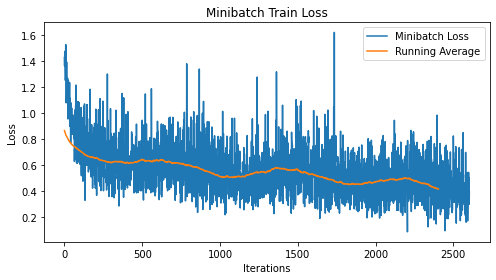

In [13]:
plot_training_batch_loss(minibatch_loss_list, num_epochs, len(train_loader))
plt.show()

**Plot train vs Validation Accuracy**

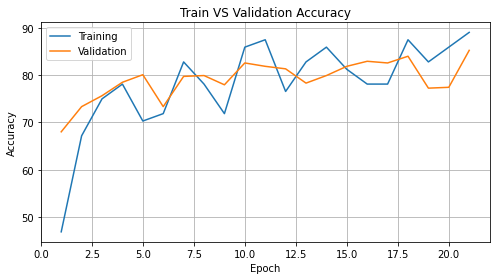

In [14]:
plot_accuracy(train_acc_list, valid_acc_list)
plt.show()

**Plot train vs Validation Loss**

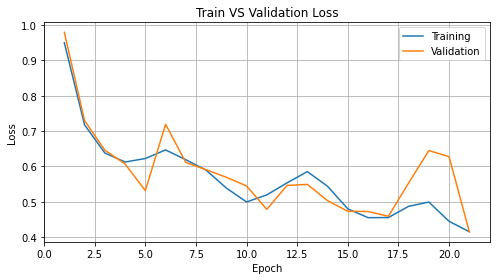

In [15]:
plot_loss(train_loss_list, valid_loss_list)
plt.show()

**Saving the loss and accuracy into file for later model comparison**

In [17]:
satellite_dataset_output_dict = {"train_acc_list":train_acc_list,"valid_acc_list":valid_acc_list, "train_loss_list":train_loss_list, "valid_loss_list": valid_loss_list}

import json 

#writing this dict to a file for later use
with open('/content/drive/MyDrive/AI Project/Model Training/Satellite_dataset_results_resnet.txt', 'w') as f:
    f.write(json.dumps(satellite_dataset_output_dict))


**Confusion Matrix**

In [18]:
label_encoding = data.class_to_idx

class_dict = {v: k for k, v in label_encoding.items()} #reverse the mapping

print(label_encoding)

{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}


In [ ]:
# label_encoding = {'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}  # assign to a variable as it will be needed while prediciting

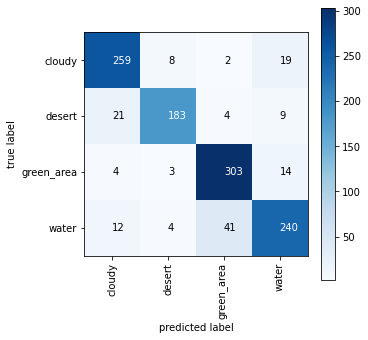

In [19]:
confusion_matrix = compute_confusion_matrix(model = model, data_loader = test_loader, device=torch.device('cuda'))
plot_confusion_matrix(confusion_matrix, class_names = class_dict.values())
plt.show()

**F1 Score, Precision and Recall**

In [20]:
print(compute_classification_report(test_loader, model, device=torch.device('cuda') ))

              precision    recall  f1-score   support

           0       0.91      0.86      0.89       305
           1       0.86      0.93      0.89       199
           2       0.92      0.84      0.88       356
           3       0.75      0.84      0.80       266

    accuracy                           0.86      1126
   macro avg       0.86      0.87      0.86      1126
weighted avg       0.87      0.86      0.86      1126



**Predicted labels Visualization**

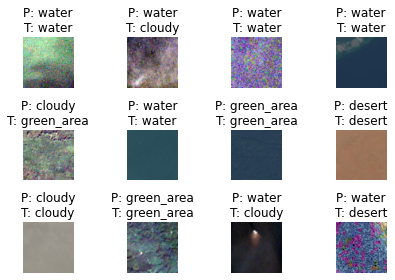

In [21]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

**Load the saved model to make predictions**

In [ ]:
model  = torch.load(path_to_save_model + file_name+'_15'+'_Intermdiate_MODEL_WEIGHTS.pth', map_location=torch.device('cpu'))

In [22]:
# test image path 
img_path = '/content/drive/MyDrive/AI Project/Model Training/test_images/water_body_1014.jpg'

In [23]:
classes = ['cloudy','desert','green_area','water']
print("The predicted class is " , predict_image_class(model, img_path, classes))

The predicted class is  water
